In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras
import json
import tensorflow as tf 
from keras.layers import Input
from keras import Sequential
from keras.layers import Dense, LSTM,Flatten, TimeDistributed, Conv2D, Dropout, Reshape
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.utils import Sequence

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
images_path = "E:/Universidad/TFM-DATOS/train"

maximum = 10

height_images = 480
width_images = 640

In [3]:
def get_img(img_path, printer=False):
    original_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if printer: print ("original dim:",original_img.shape)
    #resized_img = cv2.resize(original_img, (320,240), interpolation=cv2.INTER_CUBIC)
    #if printer: print ("resized dim:", resized_img.shape)
    return original_img

original dim: (480, 640, 3)


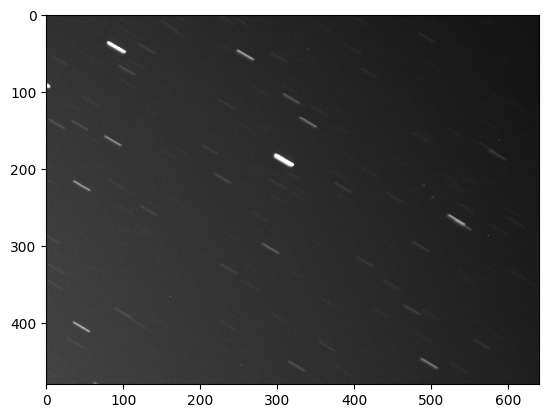

In [4]:
resized_img = get_img(images_path + "/1/1.png",True)
plt.imshow(resized_img)

In [5]:
def getLabelY(path):
    labelY = []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            class_index, x_center, y_center, p_w_norm, p_h_norm = map(float, line.strip().split())
            labelY.append(np.array([x_center,y_center]))
    if len(labelY) == 0:
        labelY.append(np.array([-1,-1]))
    return labelY

In [6]:
result = getLabelY(images_path + "/268/1.txt")
print(result)
print(np.array(result).shape)

[array([-1, -1])]
(1, 2)


In [7]:
def getSequence(path):
    X_sample = []
    Y_sample = []
    for file in os.listdir(path):
            extension = file.split('.')
            if extension[1] == "png" and len(extension[0]) == 1:
                img_path = os.path.join(path, file)
                resized_img = get_img(img_path)
                X_sample.append(resized_img)
                txt_path = os.path.join(path, extension[0] + ".txt")
                Y_sample.append(getLabelY(txt_path))
    return X_sample, Y_sample

In [8]:
sec_x, sec_y = getSequence(images_path + "/448")
print(np.array(sec_x).shape)
print(np.array(sec_y).shape)

(5, 480, 640, 3)
(5, 10, 2)


In [10]:
X_train = []
y_train = []

for folder in os.listdir(images_path):
    folder_path = os.path.join(images_path, folder)
    if os.path.isdir(folder_path):
        sec_x, sec_y = getSequence(folder_path)
        X_train.append(np.array(sec_x))
        y_train.append(np.array(sec_y))

C:\Users\Marc\AppData\Local\Temp\ipykernel_10896\3606836703.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train.append(np.array(sec_y))


In [9]:
X_train = []
y_train = []

for folder in range(200,300):
    folder_path = os.path.join(images_path, str(folder))
    if os.path.isdir(folder_path):
        sec_x, sec_y = getSequence(folder_path)
        X_train.append(np.array(sec_x))
        y_train.append(np.array(sec_y))

C:\Users\Marc\AppData\Local\Temp\ipykernel_3084\692730121.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train.append(np.array(sec_y))


In [11]:
maximum = -1
folder = 0
image = 0

for i, seci in enumerate(y_train):
    for j, secj in enumerate(seci):
        aux = len(secj)
        if aux > maximum:
            maximum = aux
            folder = i
            image = j
print(f'maximum: {maximum}, folder: {folder}, image: {image + 1}')
print(y_train[folder][image])

maximum: 10, folder: 668, image: 1
[[0.8634361  0.16128687]
 [0.88232178 0.14116053]
 [0.33093851 0.70044392]
 [0.218636   0.82906728]
 [0.33396885 0.7093128 ]
 [0.84692088 0.17262538]
 [0.24035973 0.80082758]
 [0.18896563 0.84562868]
 [0.20633493 0.85610541]
 [0.94997702 0.68826593]]


In [12]:
y_train_buena = []

for sec in y_train:
    aux = []
    for a in sec:
        b = np.full((maximum,2), -1.)
        for i,j in enumerate(a):
            b[i][0:len(j)] = j
        aux.append(b)
    y_train_buena.append(np.array(aux))
    
y_train = y_train_buena

In [13]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(1280, 5, 480, 640, 3)
(1280, 5, 10, 2)


(480, 640, 3)
x: 0.785009765625, y: 0.4939887152777779
x: 0.7662216186523437, y: 0.4621073404947917
x: 0.22011614304812815, y: 0.26894496434937615


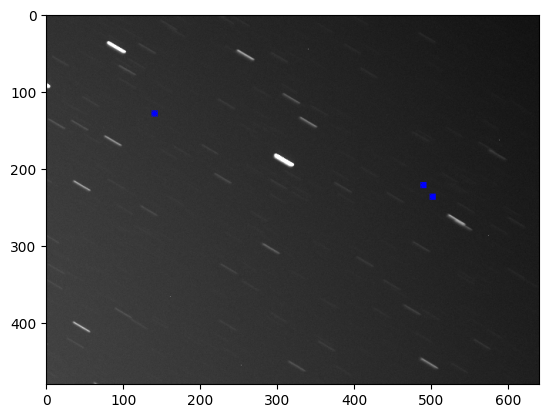

In [30]:
example = X_train[0][0]

height_images = example.shape[0]
width_images = example.shape[1]

print(example.shape)

for i in y_train[0][0]:
    x_coord = i[0]
    y_coord = i[1]
    if x_coord != -1 and y_coord != -1:
        print(f'x: {x_coord}, y: {y_coord}')

        width = (7 / width_images) / 2
        height = (7 / height_images) / 2
        
        xmin = int((x_coord - width/2) * width_images)
        ymin = int((y_coord - height/2) * height_images)
        xmax = int((x_coord + width/2) * width_images)
        ymax = int((y_coord + height/2) * height_images)

        cv2.rectangle(example, (xmin, ymin), (xmax, ymax), (0,0,255), thickness=1)
        
plt.imshow(example)
plt.show()

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11994733982752205939
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14668758157
locality {
  bus_id: 1
}
incarnation: 2694433849142929820
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [9]:
class CustomDataGenerator(Sequence):
    def __init__(self, folder_path, batch_size, maximum=10):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.maximum = maximum
        self.filenames = [i for i in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, i))]
        self.num_images = len(self.filenames)

    def __len__(self):
        return int(np.ceil(self.num_images / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_filenames = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for filename in batch_filenames:
            filepath = os.path.join(self.folder_path, filename)
            sec_x, sec_y = getSequence(filepath)
            batch_images.append(np.array(sec_x))
            batch_labels.append(np.array(sec_y))
            
        batch_labels_buena = []
        for sec in batch_labels:
            aux = []
            for a in sec:
                b = np.full((self.maximum,2), -1.)
                for i,j in enumerate(a):
                    b[i][0:len(j)] = j
                aux.append(b)
            batch_labels_buena.append(np.array(aux))
        batch_labels = batch_labels_buena
        
        return np.array(batch_images), np.array(batch_labels)

In [10]:
inceptionresnet=tf.keras.applications.InceptionResNetV2(                                       
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(height_images,width_images,3)
)
  
for layer in inceptionresnet.layers[:-4]:                                                       
    layer.trainable = False

In [11]:
model = Sequential()
#add Inception model for 5 input images (keeping the right shape)
model.add(TimeDistributed(inceptionresnet, input_shape=(5, height_images, width_images, 3)))
                     
#Using TimeDistributed Layer to Feed the Image Sequence
# now, flatten  each output to send 5 outputs with one dimension to #LSTM
model.add(TimeDistributed(Flatten()))
##Added LSTM to Capture the Sequencial Information
model.add(LSTM(256,activation='relu', return_sequences=False))
# Dense Layer
model.add(Dense(128,activation='relu'))
#Final Dense Layer
model.add(Dropout(.5))
model.add(Dense(5*maximum*2))  
model.add(Reshape((5,maximum,2)))
                     
# Final Layer is of 30 Neurons
model.compile(optimizer='adam', loss='mean_squared_error', metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 13, 18, 1536)  54336736  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 359424)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               368313344 
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               1

In [12]:
#r=model.fit(np.array(X_train),np.array(y_train),validation_split=0.2,batch_size=20,epochs=50)
generator = CustomDataGenerator(images_path, batch_size=32, maximum=maximum)
r=model.fit(generator,epochs=50)

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/time_distributed/conv2d_2/Conv2D' defined at (most recent call last):
    File "E:\anaconda3\envs\gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "E:\anaconda3\envs\gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "E:\anaconda3\envs\gpu\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "E:\anaconda3\envs\gpu\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "E:\anaconda3\envs\gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "E:\anaconda3\envs\gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "E:\anaconda3\envs\gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "E:\anaconda3\envs\gpu\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "E:\anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "E:\anaconda3\envs\gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "E:\anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "E:\anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "E:\anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Marc\AppData\Local\Temp\ipykernel_8540\1233816743.py", line 3, in <module>
      r=model.fit(generator,epochs=50)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\base_layer.py", line 1102, in __call__
      self._set_mask_metadata(
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\base_layer.py", line 2810, in _set_mask_metadata
      output_masks = self.compute_mask(inputs, previous_mask)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\layers\rnn\time_distributed.py", line 344, in compute_mask
      output_mask = self.layer.compute_mask(inner_inputs, inner_mask)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\functional.py", line 486, in compute_mask
      output_tensors = self._run_internal_graph(inputs, mask=mask)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "E:\anaconda3\envs\gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/time_distributed/conv2d_2/Conv2D'
OOM when allocating tensor with shape[160,64,237,317] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator PluggableDevice_0_bfc
	 [[{{node sequential/time_distributed/conv2d_2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_44551]

In [ ]:
model.save("D:/TFM/modelos_entrenados/2_test_CNN_LSTM.h5")

In [42]:
images_path_test = "D:/TFM/TFM-DATOS/test"

test_predict_x, test_predict_y = getSequence(images_path_test + "/1")

test_predict_x = [test_predict_x]

print(np.array(test_predict_x).shape)
print(np.array(test_predict_y).shape)

(1, 5, 240, 320, 3)
(5, 2, 2)


In [43]:
predict = model.predict(np.array(test_predict_x))

1/1 [==============================] - 1s 581ms/step


In [56]:
print(predict[0][0][0])
print(test_predict_y[0][1])

[0.09339979 0.10555435]
[0.77056169 0.54461961]


In [60]:
print(predict[0].shape)
for count, i in enumerate(predict[0]):
    print(f"Imagen {count + 1}")
    for j in i:
        if j[0] >= 0 and j[1] >= 0:
            print(f'x: {j[0]}, y: {j[1]}')
            print()
    print("Real")
    for j in test_predict_y[count]:
        print(f'x: {j[0]}, y: {j[0]}')
    print()
    print("----------------------------------------------")

(5, 15, 2)
Imagen 1
x: 0.09339979290962219, y: 0.10555434972047806

Real
x: 0.481640625, y: 0.481640625
x: 0.7705616863303497, y: 0.7705616863303497

----------------------------------------------
Imagen 2
x: 0.09837829321622849, y: 0.10528090596199036

Real
x: 0.5240636488970587, y: 0.5240636488970587
x: 0.8096241863303497, y: 0.8096241863303497

----------------------------------------------
Imagen 3
x: 0.09620747715234756, y: 0.10645069926977158

Real
x: 0.5671075994318183, y: 0.5671075994318183
x: 0.8486866863303497, y: 0.8486866863303497

----------------------------------------------
Imagen 4
x: 0.09507142007350922, y: 0.10700329393148422

Real
x: 0.6090057862633689, y: 0.6090057862633689
x: 0.8877491863303497, y: 0.8877491863303497

----------------------------------------------
Imagen 5
x: 0.09432059526443481, y: 0.10154107958078384

Real
x: 0.6515222886029413, y: 0.6515222886029413
x: 0.9268116863303497, y: 0.9268116863303497

----------------------------------------------


In [39]:
print(test_predict_y[0])

[array([0.48164062, 0.57882966]), array([0.77056169, 0.54461961])]
